# Customer Clustering and Visualization

## Import Libraries

In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create a directory for saving visualizations
import os
os.makedirs("visualizations", exist_ok=True)

import mlxtend
print(f"mlxtend version: {mlxtend.__version__}")
from mlxtend.frequent_patterns import apriori, association_rules

mlxtend version: 0.23.2


## **Step 1: Load and Explore the Dataset**

In [2]:
# Define the path to the cleaned dataset
dataset_path = 'dataset/cleaned_online_retail_data.csv'

# Load the cleaned dataset
df = pd.read_csv(dataset_path)

## Dataset Overview

In [3]:
# Display basic information about the dataset
print("Basic Information about the Dataset:")
df.info()

Basic Information about the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385081 entries, 0 to 385080
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Description            385081 non-null  object 
 1   Quantity               385081 non-null  int64  
 2   InvoiceDate            385081 non-null  object 
 3   UnitPrice              385081 non-null  float64
 4   CustomerID             385081 non-null  int64  
 5   Country                385081 non-null  object 
 6   InvoiceYear            385081 non-null  int64  
 7   InvoiceMonth           385081 non-null  int64  
 8   InvoiceDay             385081 non-null  int64  
 9   InvoiceHour            385081 non-null  int64  
 10  TotalPrice             385081 non-null  float64
 11  TransactionID          385081 non-null  object 
 12  CustomerTransactionID  385081 non-null  object 
 13  DayOfWeek              385081 non-null  object 
 14 

In [4]:
# Display descriptive statistics for numeric and categorical columns
print("\nDescriptive Statistics:")
print(df.describe(include='all'))


Descriptive Statistics:
                               Description      Quantity          InvoiceDate  \
count                               385081  385081.00000               385081   
unique                                3832           NaN                16799   
top     WHITE HANGING HEART T-LIGHT HOLDER           NaN  2011-11-14 15:27:00   
freq                                  1979           NaN                  525   
mean                                   NaN      10.00891                  NaN   
std                                    NaN      14.64235                  NaN   
min                                    NaN       1.00000                  NaN   
25%                                    NaN       2.00000                  NaN   
50%                                    NaN       6.00000                  NaN   
75%                                    NaN      12.00000                  NaN   
max                                    NaN     120.00000                  NaN   

  

In [5]:
# Display the first few rows of the dataset
print("\nPreview of the Dataset:")
print(df.head())


Preview of the Dataset:
                           Description  Quantity          InvoiceDate  \
0   WHITE HANGING HEART T-LIGHT HOLDER         6  2010-12-01 08:26:00   
1                  WHITE METAL LANTERN         6  2010-12-01 08:26:00   
2       CREAM CUPID HEARTS COAT HANGER         8  2010-12-01 08:26:00   
3  KNITTED UNION FLAG HOT WATER BOTTLE         6  2010-12-01 08:26:00   
4       RED WOOLLY HOTTIE WHITE HEART.         6  2010-12-01 08:26:00   

   UnitPrice  CustomerID         Country  InvoiceYear  InvoiceMonth  \
0       2.55       17850  United Kingdom         2010            12   
1       3.39       17850  United Kingdom         2010            12   
2       2.75       17850  United Kingdom         2010            12   
3       3.39       17850  United Kingdom         2010            12   
4       3.39       17850  United Kingdom         2010            12   

   InvoiceDay  InvoiceHour  ...  DayOfWeek WeekOfYear Quarter YearMonth  \
0           1            8  ...  W

### **Explanation**:
- The dataset contains transaction-level data for a UK-based retailer. 
- Columns include customer purchasing behaviors (e.g., PurchaseFrequency, TotalAmountSpent), 
- temporal data (e.g., InvoiceYear, InvoiceMonth), and product-level metrics (e.g., UnitPrice, TotalPrice).


## **Step 2: Define Feature Sets for Clustering**
- Feature sets are chosen to gain specific insights into customer behavior and segmentation.


In [6]:
feature_sets = {
    "Set 1: Purchasing Behavior": ['PurchaseFrequency', 'TotalAmountSpent', 'AveragePurchaseValue'],
    # Insight: Segment customers based on their purchasing frequency and spending patterns to identify high-value customers.

    "Set 2: Time-Based Behavior": ['InvoiceYear', 'InvoiceMonth', 'InvoiceDay', 'InvoiceHour'],
    # Insight: Identify clusters of customers based on their purchasing patterns over time (e.g., seasonality, hours of activity).

    "Set 3: Pricing Analysis": ['UnitPrice', 'TotalPrice'],
    # Insight: Cluster customers based on the pricing of items they purchase and the total revenue generated.

    "Set 4: Spending Trends (USD)": ['UnitPrice_USD', 'TotalPrice_USD'],
    # Insight: Perform similar analysis as Set 3 but in USD for international relevance.

    "Set 5: Order Size and Spending": ['OrderSize', 'TotalAmountSpent', 'PurchaseFrequency']
    # Insight: Combine the size of orders (Small, Medium, Large) with spending behavior to understand customer types.
}

### **Explanation**:
- These feature sets are designed to focus on different aspects of customer behavior:
   - Purchasing behavior (frequency, spending)
   - Time-based trends
   - Price-based patterns
   - Order size and spending trends

## **Step 3: Helper Functions**

In [7]:
## Step 3: Helper Functions
def preprocess_features(features_df):
    """Preprocess the features by scaling and encoding."""
    if features_df.isnull().any().any():
        raise ValueError("Feature set contains NaN values. Clean the data before scaling.")
    if np.isinf(features_df.select_dtypes(include=[np.number]).values).any():
        raise ValueError("Feature set contains infinite values.")
    if features_df.select_dtypes(include=['object']).shape[1] > 0:
        features_df = pd.get_dummies(features_df, drop_first=True)

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)
    return scaled_features

def determine_optimal_clusters(features_scaled, set_name, max_k=10):
    """Determine the optimal number of clusters using the elbow method and silhouette analysis."""
    inertia, silhouette_scores, k_values = [], [], range(2, max_k + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
        kmeans.fit(features_scaled)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

    # Plot Elbow Method
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertia, marker='o', linestyle='--')
    plt.title(f'Elbow Method for {set_name}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"visualizations/{set_name.replace(':', '_').replace(' ', '_')}_elbow.png")
    plt.show()

    # Plot Silhouette Scores
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='purple')
    plt.title(f'Silhouette Scores for {set_name}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"visualizations/{set_name.replace(':', '_').replace(' ', '_')}_silhouette.png")
    plt.show()

    # Return optimal K based on the highest silhouette score
    optimal_k = k_values[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters for {set_name}: {optimal_k}")
    return optimal_k

def perform_clustering(features_scaled, optimal_k, set_name, df):
    """Perform clustering and assign labels dynamically."""
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, max_iter=300)
    clusters = kmeans.fit_predict(features_scaled)

    cluster_col = f'Cluster_{set_name.split(":")[1].strip()}'
    df[cluster_col] = clusters

    # Segment Analysis for Insights
    segment_analysis = df.groupby(cluster_col).agg({
        'PurchaseFrequency': ['mean', 'std'],
        'TotalAmountSpent': ['mean', 'std'],
        'AveragePurchaseValue': ['mean', 'std']
    }).reset_index()
    segment_analysis.columns = [cluster_col] + [f'{col[0]}_{col[1]}' for col in segment_analysis.columns[1:]]
    return df, segment_analysis, cluster_col

def plot_clusters(features_df, label_col, title, x_feature, y_feature, file_name):
    """Visualize clusters in a scatterplot."""
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=features_df[x_feature],
        y=features_df[y_feature],
        hue=features_df[label_col],
        palette="tab10",
        s=50,
        alpha=0.8
    )
    plt.title(title)
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"visualizations/{file_name}.png")
    plt.show()

def plot_bar(feature, cluster_col, title, file_name):
    """Visualize the average value of a feature by cluster."""
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=cluster_col,
        y=feature,
        data=df,
        errorbar=None,  # Updated to remove deprecated warning
        hue=None,
        palette="tab10"
    )
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"visualizations/{file_name}.png")
    plt.show()

## **Step 4: Perform Clustering for Each Feature Set**

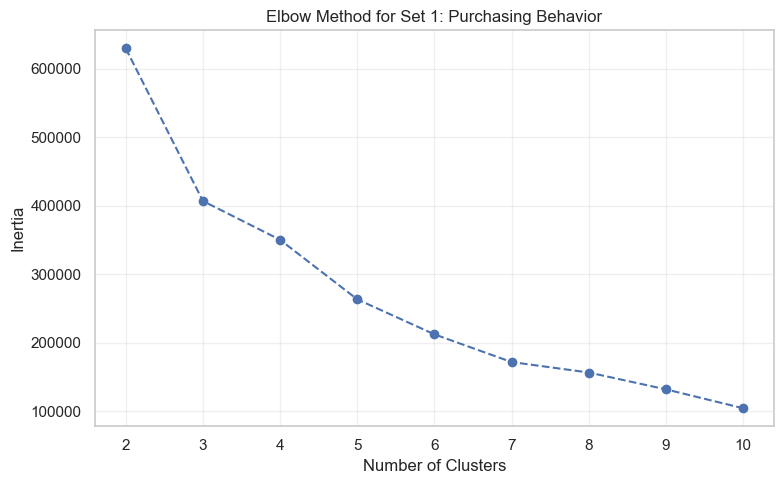

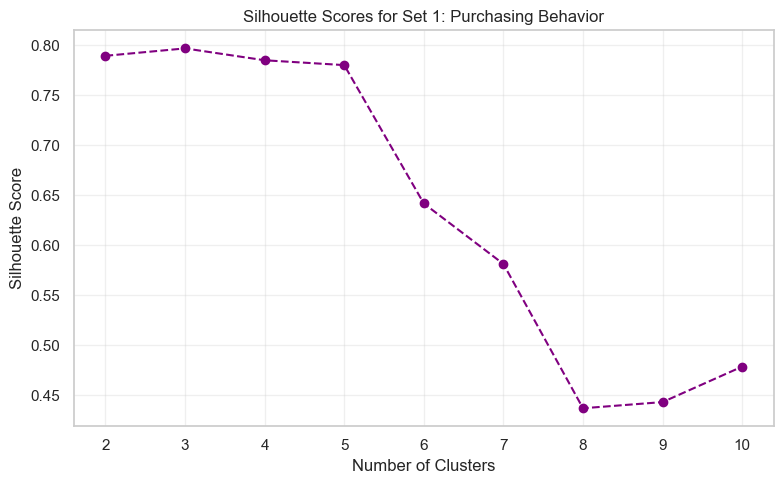

Optimal number of clusters for Set 1: Purchasing Behavior: 3


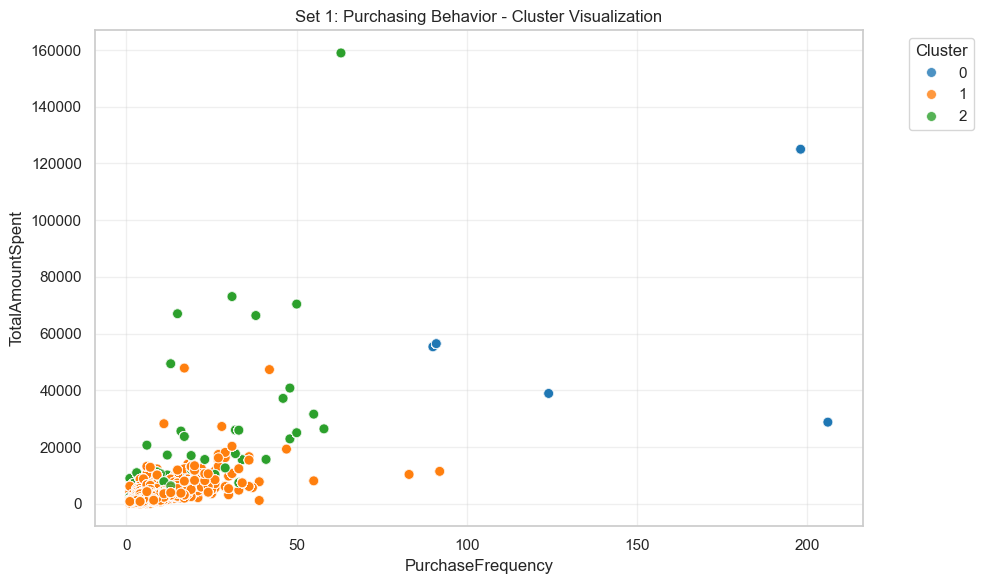

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24388\2638693009.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


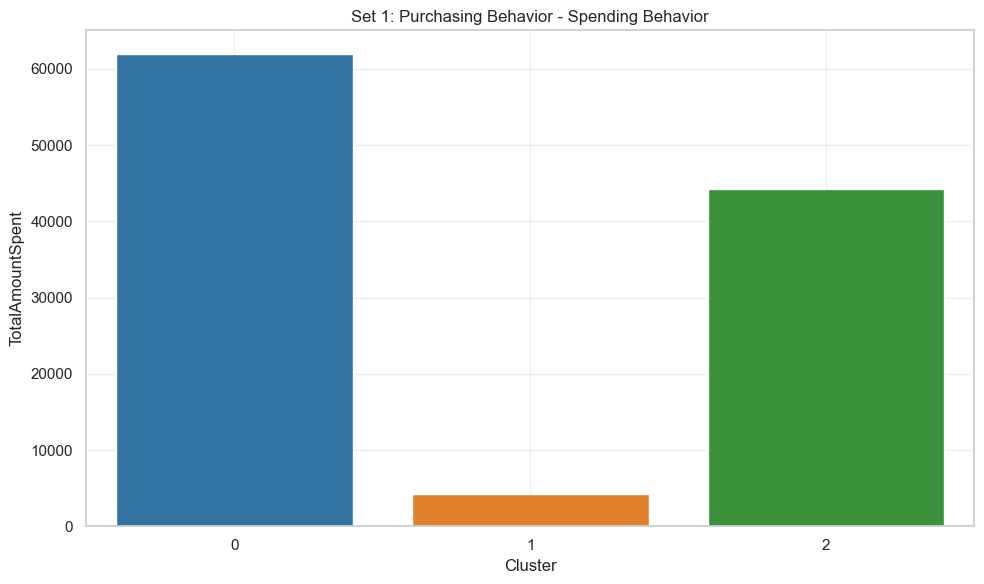

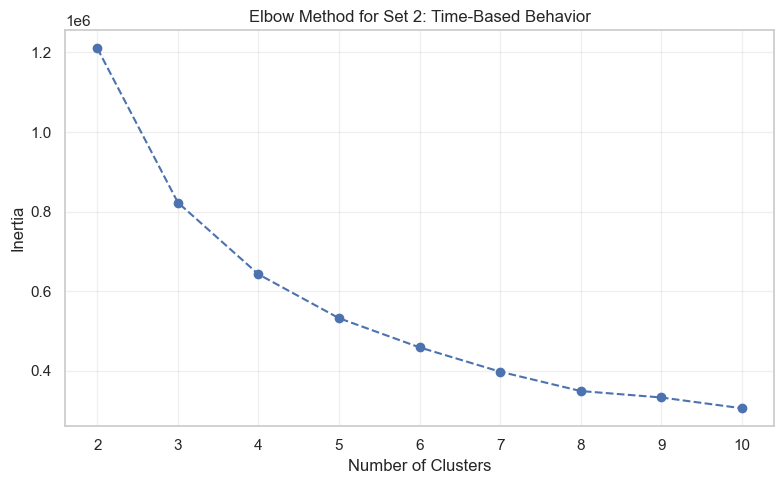

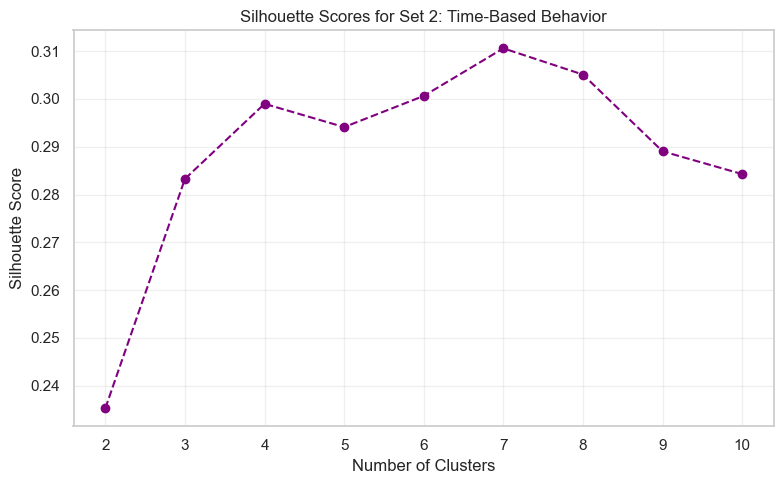

Optimal number of clusters for Set 2: Time-Based Behavior: 7


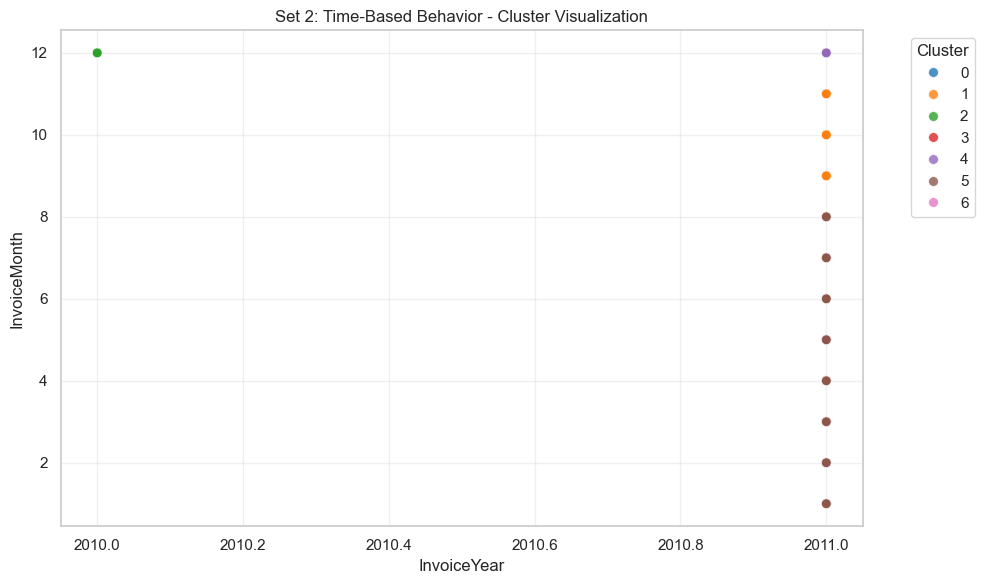

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24388\2638693009.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


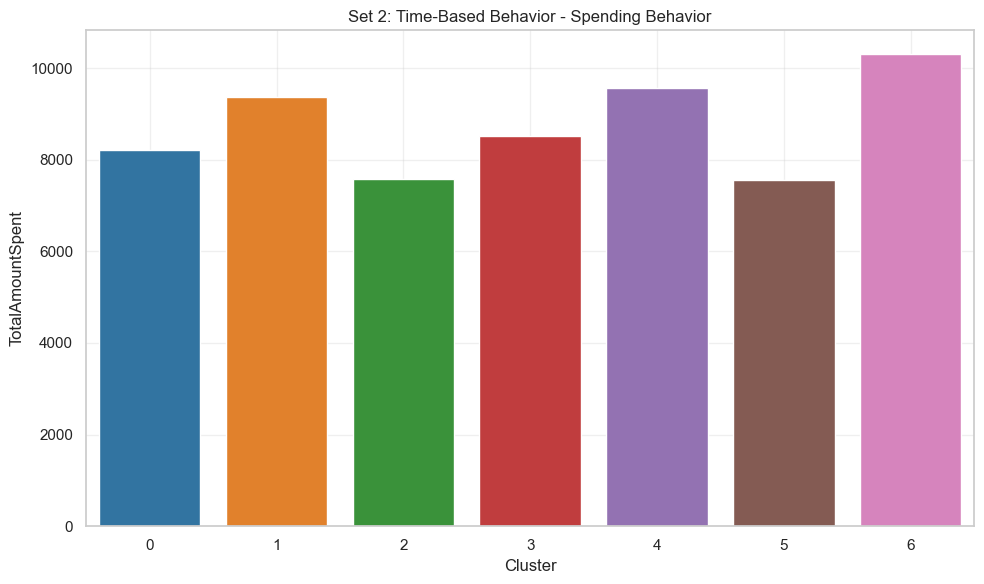

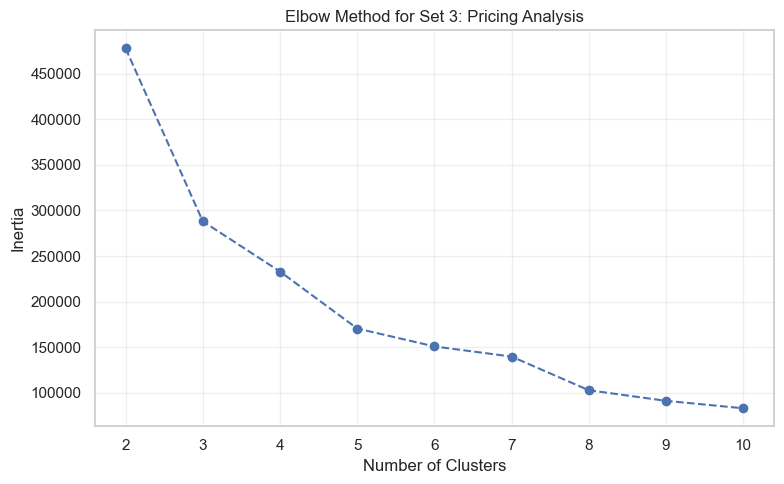

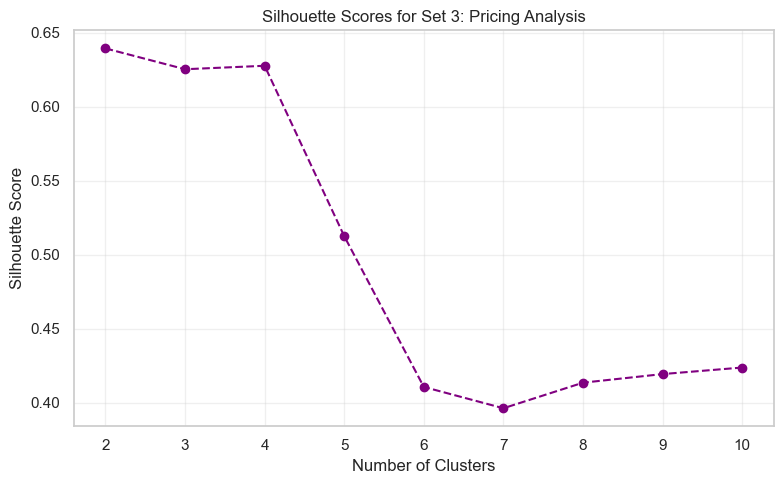

Optimal number of clusters for Set 3: Pricing Analysis: 2


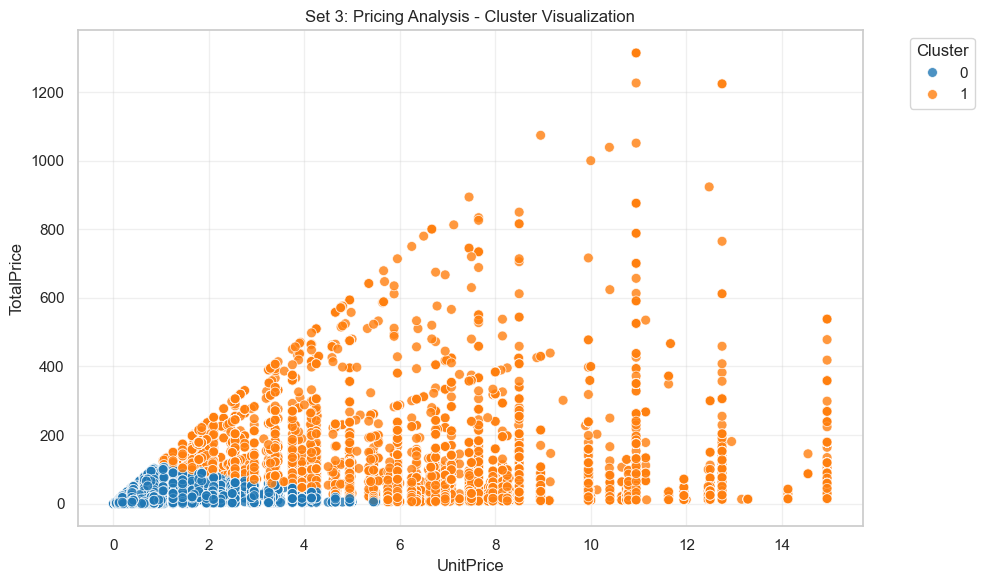

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24388\2638693009.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


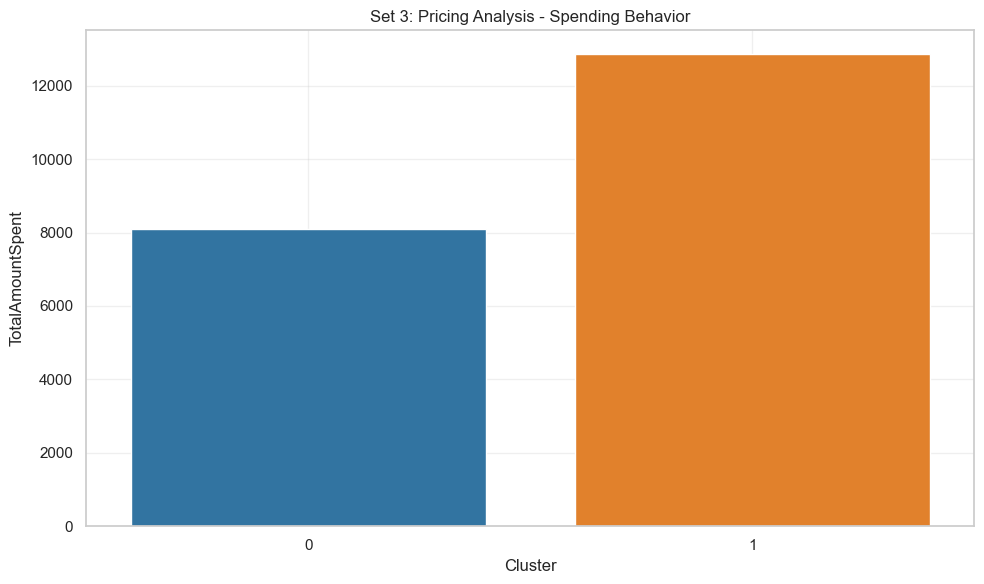

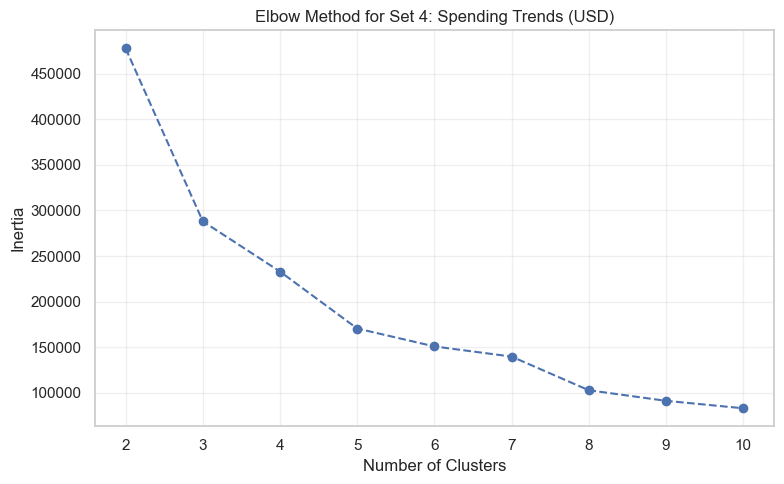

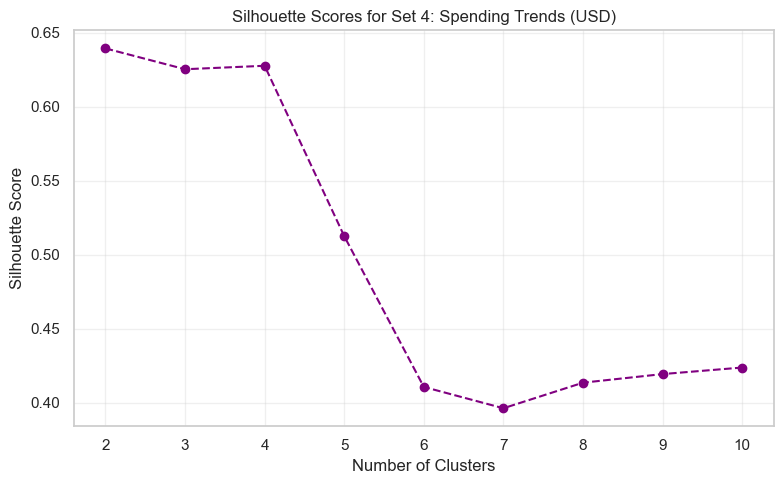

Optimal number of clusters for Set 4: Spending Trends (USD): 2


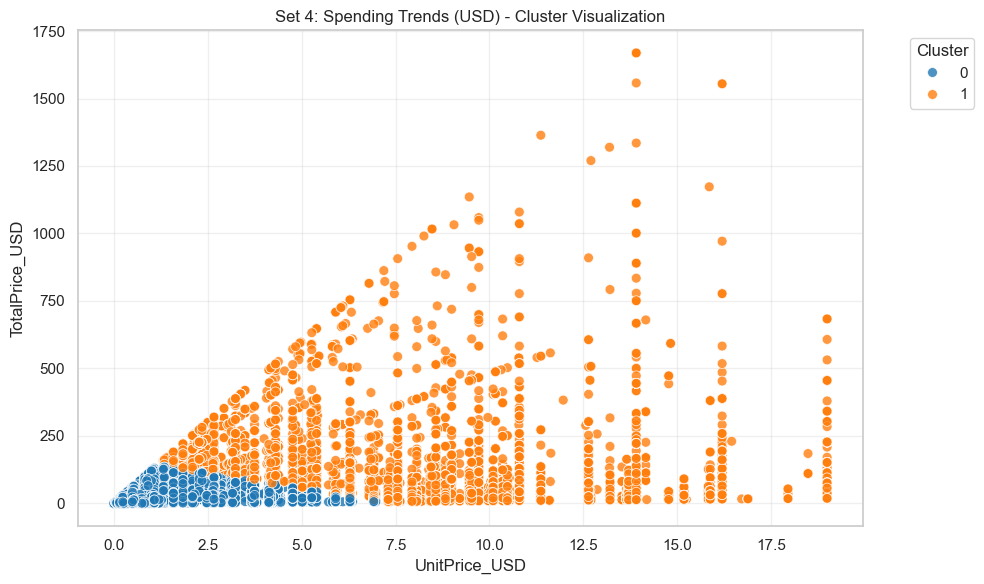

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24388\2638693009.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


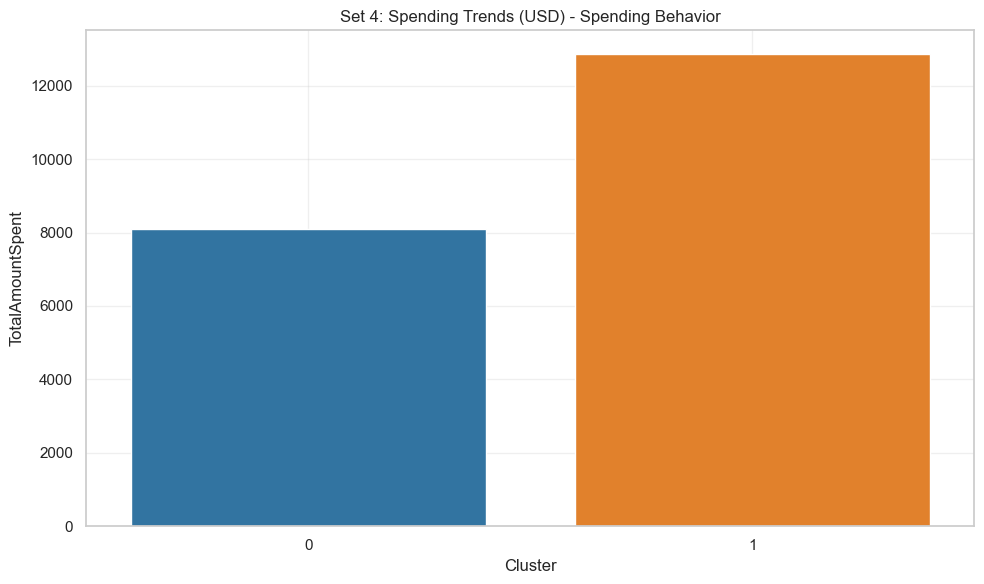

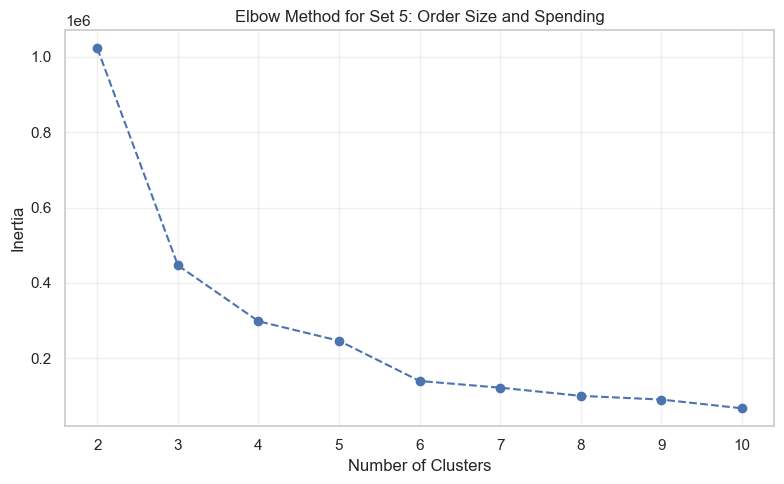

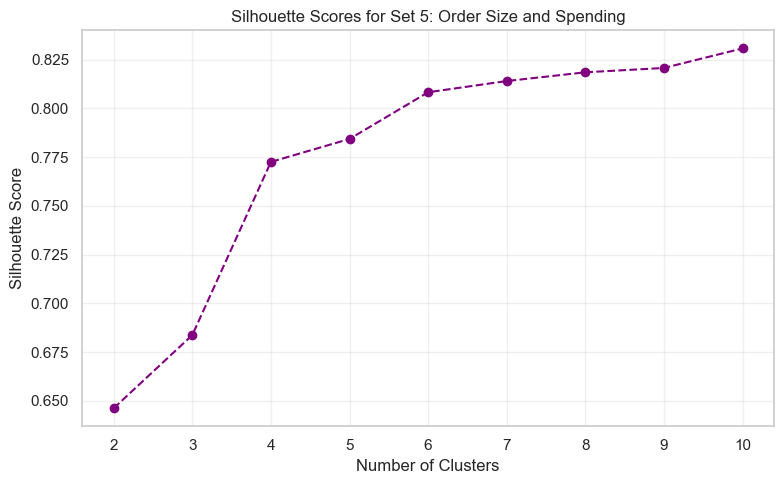

Optimal number of clusters for Set 5: Order Size and Spending: 10


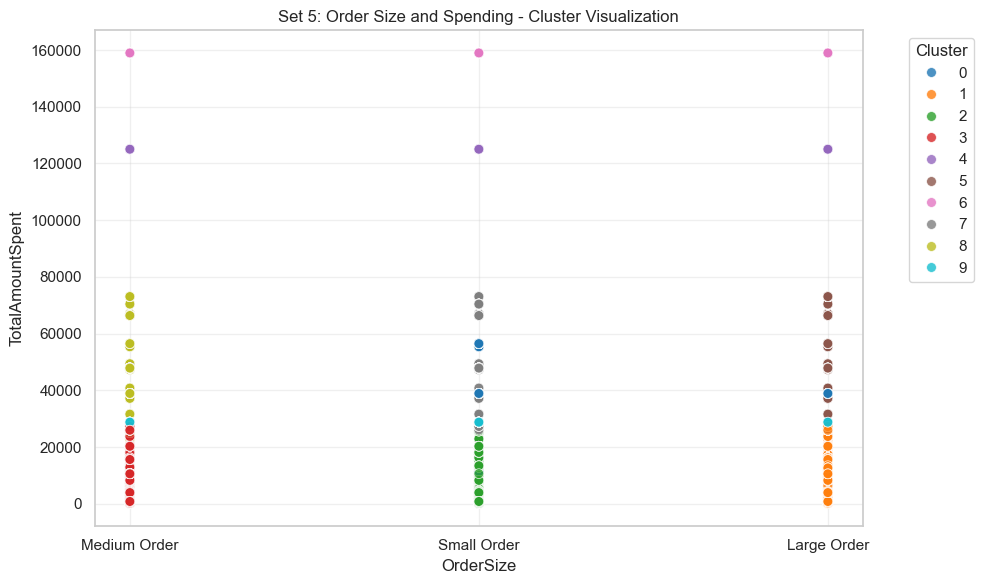

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24388\2638693009.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


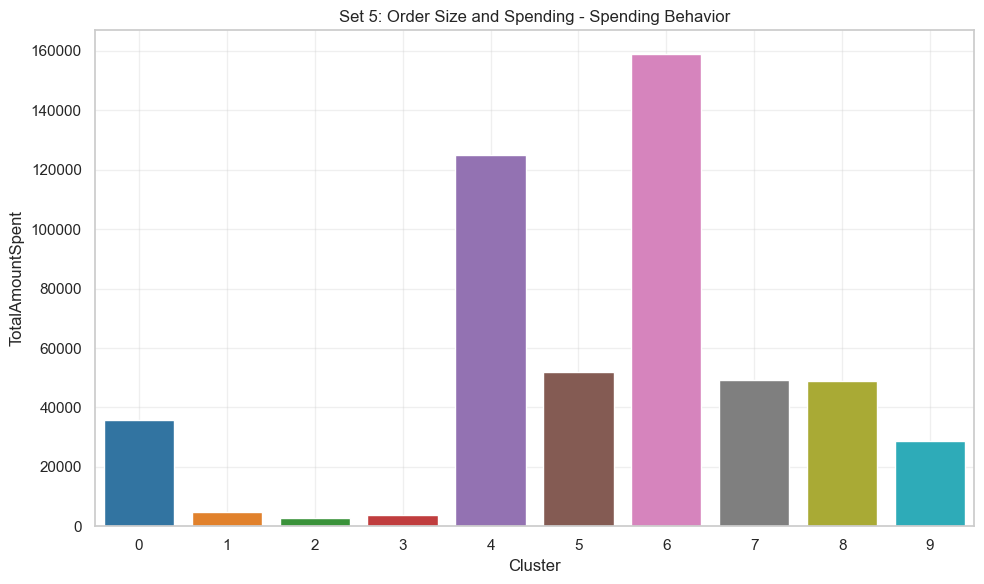

In [8]:
results = {}

 
for set_name, features in feature_sets.items():
    features_df = df[features]
    features_scaled = preprocess_features(features_df)
    optimal_k = determine_optimal_clusters(features_scaled, set_name)
    df, segment_analysis, cluster_col = perform_clustering(features_scaled, optimal_k, set_name, df)
    results[set_name] = segment_analysis
    x_feature, y_feature = features[:2]
    plot_clusters(df, cluster_col, f"{set_name} - Cluster Visualization", x_feature, y_feature,
                  f"{set_name.split(':')[1].strip().replace(' ', '_')}_clusters")
    plot_bar("TotalAmountSpent", cluster_col, f"{set_name} - Spending Behavior",
             f"{set_name.split(':')[1].strip().replace(' ', '_')}_spending")


## **Step 5: Save Results**

In [9]:
for set_name, analysis in results.items():
    file_name = f'analysis/segment_analysis_{set_name.split(":")[1].strip().replace(" ", "_")}.csv'
    analysis.to_csv(file_name, index=False)
    print(f"Saved segment analysis for {set_name} as: {file_name}")

print("Clustering and visualization completed.") 

Saved segment analysis for Set 1: Purchasing Behavior as: analysis/segment_analysis_Purchasing_Behavior.csv
Saved segment analysis for Set 2: Time-Based Behavior as: analysis/segment_analysis_Time-Based_Behavior.csv
Saved segment analysis for Set 3: Pricing Analysis as: analysis/segment_analysis_Pricing_Analysis.csv
Saved segment analysis for Set 4: Spending Trends (USD) as: analysis/segment_analysis_Spending_Trends_(USD).csv
Saved segment analysis for Set 5: Order Size and Spending as: analysis/segment_analysis_Order_Size_and_Spending.csv
Clustering and visualization completed.


### **Explanation of Results**
- **Set 1**: Identifies high-value vs. low-value customers based on spending.
- **Set 2**: Identifies customer purchasing trends over time (e.g., seasonal or hourly activity).
- **Set 3/4**: Groups customers based on pricing patterns.
- **Set 5**: Analyzes customer types based on order size and spending behavior.

## Step 6: Association Learning Analysis

In [12]:
# Load the specified dataset
df = pd.read_csv('dataset/cleaned_online_retail_data.csv')

# Sample the data
df_sampled = df.sample(frac=0.1, random_state=42)


In [13]:
# Define batch processing function
def process_batch(batch):
    pivot_table = pd.pivot_table(
        data=batch,
        values='Quantity',
        index='TransactionID',
        columns='Description',
        aggfunc='sum'
    ).fillna(0)
    pivot_table = pivot_table.apply(lambda col: col.map(lambda x: 1 if x > 0 else 0))
    return pivot_table

In [14]:
# Process data in batches
batch_size = 5000
baskets = []
for i in range(0, len(df_sampled), batch_size):
    batch = df_sampled.iloc[i:i + batch_size]
    baskets.append(process_batch(batch))

basket = pd.concat(baskets, axis=0)
basket = basket.fillna(False).astype(bool)

In [15]:
# Apply Apriori
frequent_itemsets = apriori(basket, min_support=0.005, use_colnames=True)
if frequent_itemsets.empty:
    frequent_itemsets = apriori(basket, min_support=0.001, use_colnames=True)

# Ensure itemsets are frozensets
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(frozenset)

In [ ]:
# Function to compute association rules
def compute_association_rules(frequent_itemsets, min_confidence=0.5):
    rules_list = []
    frequent_itemsets_dict = {
        frozenset(item): support for item, support in zip(frequent_itemsets['itemsets'], frequent_itemsets['support'])
    }

    for _, row in frequent_itemsets.iterrows():
        items = row['itemsets']
        support = row['support']

        if len(items) > 1:
            for item in items:
                antecedent = frozenset([item])
                consequent = items - antecedent

                antecedent_support = frequent_itemsets_dict.get(antecedent, 0)
                consequent_support = frequent_itemsets_dict.get(consequent, 0)

                if antecedent_support > 0:
                    confidence = support / antecedent_support
                    lift = confidence / consequent_support if consequent_support > 0 else 0

                    if confidence >= min_confidence:
                        rules_list.append({
                            'antecedent': antecedent,
                            'consequent': consequent,
                            'support': support,
                            'confidence': confidence,
                            'lift': lift
                        })
    return pd.DataFrame(rules_list)

In [17]:
# Compute association rules
rules_df = compute_association_rules(frequent_itemsets)
if rules_df.empty:
    print("No association rules found.")
else:
    print("High-confidence Association Rules:")
    print(rules_df.sort_values('confidence', ascending=False).head())

No association rules found.


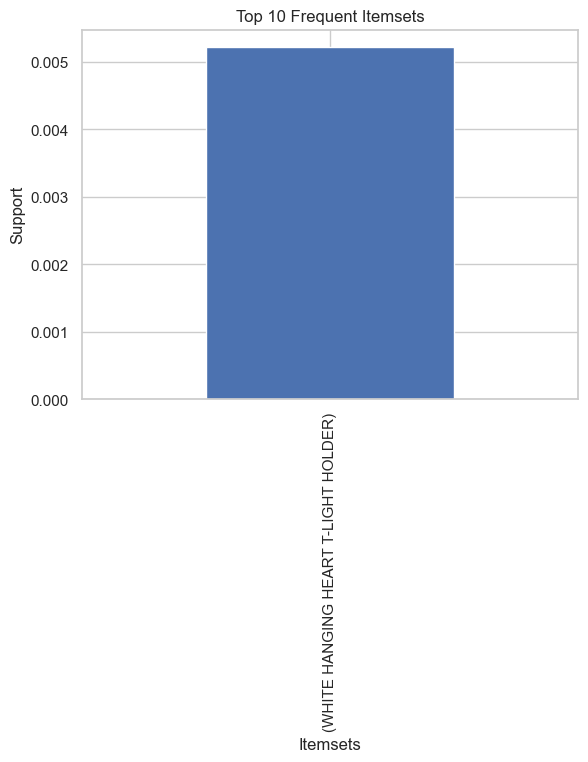

In [18]:
# Visualization
if not frequent_itemsets.empty:
    frequent_itemsets.head(10).plot(kind='bar', x='itemsets', y='support', legend=False)
    plt.title('Top 10 Frequent Itemsets')
    plt.ylabel('Support')
    plt.xlabel('Itemsets')
    plt.show()

if not rules_df.empty:
    plt.scatter(rules_df['confidence'], rules_df['lift'], alpha=0.6)
    plt.title('Confidence vs. Lift')
    plt.xlabel('Confidence')
    plt.ylabel('Lift')
    plt.show()